## TCR sequencing power analysis

I have simulated 1 million TCR sequences from which to sample to get an idea of how many cells we need to get an accurate representation of the TCR repetoire.  The only step in thymocyte development I have assumed is beta- and positive selection, i.e. there is a functional pair of alpha and beta chains in each T cell.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import scipy
import math
import itertools
import re

%matplotlib inline

In [3]:
infile = "~/Dropbox/AgeingExperiment/TCR_simulations/1Million_TCRs.txt"

# I need to randomly sample different numbers of TCRs from 100-100K, I'll use ~ 1/2 order of magnitude jumps with 
# a few extra's in between
n_total = 1000000
n_samples = [100, 500, 1000, 5000, 10000, 50000, 100000]

# for each sample randomly choose integer values between 0 and the number of cells to sample
sample_ints = [random.sample(range(n_total), x) for x in n_samples]
all_sampled = set(itertools.chain.from_iterable(sample_ints))

In [4]:
# need tp selectively remove x% of each segment
lose_trav = "TRAV2"
lose_trbv = "TRBV1"

pc_samples = [0.01, 0.05, 0.1, 0.25, 0.5]

In [5]:
# read each line and pull out the sampled ones
chunksize = 10000
file_block = pd.read_table(infile, index_col=None, sep="\t", header=0, iterator=True,
                          chunksize=chunksize)
count = 0
sampled_df = []

va_perturb_dict = []
vb_perturb_dict = []

for df_ in file_block:
    df_ = df_.loc[df_["Valid.TCR"].isin([True]), ]
    # select the line numbers in the 'all_sampled' list
    
    df_["LineNumber"] = range(count, count + df_.shape[0])
    df_ = df_.loc[df_.LineNumber.isin(all_sampled), :]
    
    if df_.shape[0] > 0:
        sampled_df.append(df_)
        
    # remove 10% of V alpha and V beta
    vb_df = df_.loc[df_["TRB_V"].isin([lose_trbv])]
    va_df = df_.loc[df_["TRA_V"].isin([lose_trav])]
    
    # randomly sample X% to remove
    for i in pc_samples:
        vb_samp = random.sample(list(vb_df.LineNumber), int(vb_df.shape[0] * i))
        vb_ = df_.loc[~df_.LineNumber.isin(vb_samp)]
        vb_["EffectSize"] = i
        
        va_samp = random.sample(list(va_df.LineNumber), int(va_df.shape[0] * i))
        va_ = df_.loc[~df_.LineNumber.isin(va_samp)]        
        va_["EffectSize"] = i
        
        va_perturb_dict.append(va_)
        vb_perturb_dict.append(vb_)
            
    count += df_.shape[0]

/Users/morgan02/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/morgan02/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
va_perturb_data = pd.concat(va_perturb_dict, axis=0)
vb_perturb_data = pd.concat(vb_perturb_dict, axis=0)

In [7]:
# concatenate the data frames
sampled_data = pd.concat(sampled_df, axis=0)
sampled_data.shape

(158270, 28)

In [8]:
# now calculate different metrics and measures of diversity.  Firstly, CDR entropy
entropy_dict = {}
cdr3_len_dict = {}

vseg_use_dict = {}
jseg_use_dict = {}

chain_pairing_dict = {}
segment_pairing_dict = {}

tra_cdr3_clones = {}
trb_cdr3_clones = {}

for i in range(len(n_samples)):
    n_samp = n_samples[i]
    sample_lines = sample_ints[i]
    
    samp_df = sampled_data.loc[sampled_data.LineNumber.isin(sample_lines), ]
    
    entropy_dict[str(n_samp)] = pd.melt(pd.DataFrame({"alpha": samp_df.TRA_CDR3_entropy,
                                                      "beta": samp_df.TRB_CDR3_entropy}))
    
    cdr3_len_dict[str(n_samp)] = pd.melt(pd.DataFrame({"alpha": samp_df.TRB_CDR3.astype(str).apply(len),
                                                       "beta": samp_df.TRB_CDR3.astype(str).apply(len)}))
    
    # count the occurences of specific CDR3 sequences to get a total diversity
    tra_cdr3_clones[str(n_samp)] = samp_df.TRA_CDR3.value_counts()
    trb_cdr3_clones[str(n_samp)] = samp_df.TRB_CDR3.value_counts()
    
    # need calculate percentage rather than absolute counts
    vseg_use = pd.DataFrame({"alpha": samp_df.TRA_V.value_counts()/n_samp,
                             "beta": samp_df.TRB_V.value_counts()/n_samp})
    vseg_use.reset_index(inplace=True)
    vseg_use.columns = ["Segment", "alpha", "beta"]
    
    vseg_use_dict[str(n_samp)] = pd.melt(vseg_use, id_vars="Segment")
       
    jseg_use = pd.DataFrame({"alpha": samp_df.TRA_J.value_counts()/n_samp,
                             "beta": samp_df.TRB_J.value_counts()/n_samp})
    jseg_use.reset_index(inplace=True)
    jseg_use.columns = ["Segment", "alpha", "beta"]
    
    jseg_use_dict[str(n_samp)] = pd.melt(jseg_use, id_vars="Segment")
    
    # record the V and J pairing within a chain
    samp_df.loc[:, "AlphaPair"] = samp_df.apply(lambda X: "_".join([X.TRA_V, X.TRA_J]), axis=1)
    samp_df.loc[:, "BetaPair"] = samp_df.apply(lambda X: "_".join([X.TRB_V, X.TRB_J]), axis=1)
    
    pair_use = pd.DataFrame({"alpha": samp_df.AlphaPair.value_counts()/n_samp,
                              "beta": samp_df.BetaPair.value_counts()/n_samp})
    pair_use.reset_index(inplace=True)
    pair_use.columns = ["Pair", "alpha", "beta"]
    
    segment_pairing_dict[str(n_samp)] = pd.melt(pair_use, id_vars="Pair")
    
    # record the V and J pairing between chains
    samp_df.loc[:, "Vpair"] = samp_df.apply(lambda X: "_".join([X.TRA_V, X.TRB_V]), axis=1)
    samp_df.loc[:, "Jpair"] = samp_df.apply(lambda X: "_".join([X.TRA_J, X.TRB_J]), axis=1)
    
    chain_use = pd.DataFrame({"Vseg": samp_df.Vpair.value_counts()/n_samp,
                              "Jseg": samp_df.Jpair.value_counts()/n_samp})
    chain_use.reset_index(inplace=True)
    chain_use.columns = ["Pair", "Vseg", "Jseg"]
    
    chain_pairing_dict[str(n_samp)] = pd.melt(chain_use, id_vars="Pair")
    
    print(samp_df.shape)
    

/Users/morgan02/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/morgan02/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(68, 32)
(516, 32)
(1021, 32)
(4997, 32)
(10026, 32)
(50009, 32)
(99219, 32)


In [9]:
entropy_df = pd.concat(entropy_dict)
entropy_df.reset_index(inplace=True)
entropy_df.columns = ["Sample", "Level", "Chain", "Entropy"]
entropy_df.loc[entropy_df.Entropy.isna(), "Entropy"] = 0


length_df = pd.concat(cdr3_len_dict)
length_df.reset_index(inplace=True)
length_df.columns = ["Sample", "Level", "Chain", "Length"]
length_df.loc[length_df.Length.isna(), "Length"] = 0

In [10]:
vseg_df = pd.concat(vseg_use_dict)
vseg_df.reset_index(inplace=True)
vseg_df.columns = ["Sample", "Level", "Segment", "Chain", "Counts"]
# remove TRAV segments from the beta chains
vseg_df = vseg_df.loc[~((vseg_df["Chain"] == "beta") & (vseg_df["Segment"].str.contains("TRAV")))]
vseg_df = vseg_df.loc[~((vseg_df["Chain"] == "alpha") & (vseg_df["Segment"].str.contains("TRBV")))]
vseg_df.loc[vseg_df.Counts.isna(), "Counts"] = 0

In [11]:
jseg_df = pd.concat(jseg_use_dict)
jseg_df.reset_index(inplace=True)
jseg_df.columns = ["Sample", "Level", "Segment", "Chain", "Counts"]
# remove TRAV segments from the beta chains
jseg_df = jseg_df.loc[~((jseg_df["Chain"] == "beta") & (jseg_df["Segment"].str.contains("TRAJ")))]
jseg_df = jseg_df.loc[~((jseg_df["Chain"] == "alpha") & (jseg_df["Segment"].str.contains("TRBJ")))]
jseg_df.loc[jseg_df.Counts.isna(), "Counts"] = 0

In [12]:
traj_segs = set(jseg_df.Segment.loc[jseg_df.Segment.str.contains("TRAJ")].values)
trbj_segs = set(jseg_df.Segment.loc[jseg_df.Segment.str.contains("TRBJ")].values)

trav_segs = set(vseg_df.Segment.loc[vseg_df.Segment.str.contains("TRAV")].values)
trbv_segs = set(vseg_df.Segment.loc[vseg_df.Segment.str.contains("TRBV")].values)

v_combs = ["_".join(v) for v in itertools.product(trav_segs, trbv_segs)]
j_combs = ["_".join(j) for j in itertools.product(traj_segs, trbj_segs)]

alpha_combs = ["_".join(av) for av in itertools.product(trav_segs, traj_segs)]
beta_combs = ["_".join(bv) for bv in itertools.product(trbv_segs, trbj_segs)]

In [44]:
# now calculate different metrics and measures of diversity.  Firstly, CDR entropy

#va_perturb_data
#vb_perturb_data
va_lines = va_perturb_data.shape[0]
vb_lines = vb_perturb_data.shape[0]

perturb_entropy_dict = {}
perturb_cdr3_len_dict = {}

perturb_vseg_use_dict = {}
perturb_jseg_use_dict = {}

perturb_chain_pairing_dict = {}
perturb_segment_pairing_dict = {}

perturb_tra_cdr3_clones = {}
perturb_trb_cdr3_clones = {}

for x in range(len(n_samples)):
    n_samp = n_samples[x]
        
    # summarise within each effect size
    va_pc_entropy_list = []
    vb_pc_entropy_list = []
    
    va_pc_usage_list = []
    vb_pc_usage_list = []    
    
    for i in pc_samples:
        va_eff_df = va_perturb_data.loc[va_perturb_data.EffectSize == i]
        vb_eff_df = vb_perturb_data.loc[vb_perturb_data.EffectSize == i]
        
        va_sampl = random.sample(range(va_eff_df.shape[0]), n_samp)
        vb_sampl = random.sample(range(vb_eff_df.shape[0]), n_samp)

        va_samp = va_eff_df.iloc[va_sampl]
        vb_samp = vb_eff_df.iloc[vb_sampl]
        
        
        # changes in entropy
        va_ent = pd.melt(pd.DataFrame(va_samp.TRA_CDR3_entropy))
        va_ent["EffectSize"] = i
        
        vb_ent = pd.melt(pd.DataFrame(vb_samp.TRB_CDR3_entropy))
        vb_ent["EffectSize"] = i
        
        va_pc_entropy_list.append(va_ent)
        vb_pc_entropy_list.append(vb_ent)
        
        # changes in V usage
        va_usage = pd.DataFrame(va_samp.TRA_V.value_counts()/va_samp.shape[0])
        va_usage.reset_index(inplace=True)
        va_usage.columns = ["Segment", "Frequency"]
        va_usage = pd.melt(va_usage, id_vars=["Segment"])
        va_usage["EffectSize"] = i
        
        va_pc_usage_list.append(va_usage)
        
        vb_usage = pd.DataFrame(vb_samp.TRB_V.value_counts()/vb_samp.shape[0])
        vb_usage.reset_index(inplace=True)
        vb_usage.columns = ["Segment", "Frequency"]
        vb_usage = pd.melt(vb_usage, id_vars=["Segment"])
        vb_usage["EffectSize"] = i
        
        vb_pc_usage_list.append(vb_usage)
        
        
    va_entropy_perturb = pd.concat(va_pc_entropy_list)
    va_entropy_perturb["Sample"] = n_samp
    
    vb_entropy_perturb = pd.concat(vb_pc_entropy_list)
    vb_entropy_perturb["Sample"] = n_samp
    
    perturb_entropy_dict[str(n_samp)] = pd.concat([va_entropy_perturb, vb_entropy_perturb])
    
    va_usage_perturb = pd.concat(va_pc_usage_list)
    va_usage_perturb["Sample"] = n_samp
    
    vb_usage_perturb = pd.concat(vb_pc_usage_list)
    vb_usage_perturb["Sample"] = n_samp
        
    perturb_vseg_use_dict[str(n_samp)] = pd.concat([va_usage_perturb, vb_usage_perturb])
        
        #print(va_eff_df.head())
    #break
        
    
#     sample_lines = sample_ints[i]
    
#     samp_df = sampled_data.loc[sampled_data.LineNumber.isin(sample_lines), ]
    
#     
    
#     cdr3_len_dict[str(n_samp)] = pd.melt(pd.DataFrame({"alpha": samp_df.TRB_CDR3.astype(str).apply(len),
#                                                        "beta": samp_df.TRB_CDR3.astype(str).apply(len)}))
    
#     # count the occurences of specific CDR3 sequences to get a total diversity
#     tra_cdr3_clones[str(n_samp)] = samp_df.TRA_CDR3.value_counts()
#     trb_cdr3_clones[str(n_samp)] = samp_df.TRB_CDR3.value_counts()
    
#     # need calculate percentage rather than absolute counts
#     vseg_use = pd.DataFrame({"alpha": samp_df.TRA_V.value_counts()/n_samp,
#                              "beta": samp_df.TRB_V.value_counts()/n_samp})
#     vseg_use.reset_index(inplace=True)
#     vseg_use.columns = ["Segment", "alpha", "beta"]
    
#     vseg_use_dict[str(n_samp)] = pd.melt(vseg_use, id_vars="Segment")
       
#     jseg_use = pd.DataFrame({"alpha": samp_df.TRA_J.value_counts()/n_samp,
#                              "beta": samp_df.TRB_J.value_counts()/n_samp})
#     jseg_use.reset_index(inplace=True)
#     jseg_use.columns = ["Segment", "alpha", "beta"]
    
#     jseg_use_dict[str(n_samp)] = pd.melt(jseg_use, id_vars="Segment")
    
#     # record the V and J pairing within a chain
#     samp_df.loc[:, "AlphaPair"] = samp_df.apply(lambda X: "_".join([X.TRA_V, X.TRA_J]), axis=1)
#     samp_df.loc[:, "BetaPair"] = samp_df.apply(lambda X: "_".join([X.TRB_V, X.TRB_J]), axis=1)
    
#     pair_use = pd.DataFrame({"alpha": samp_df.AlphaPair.value_counts()/n_samp,
#                               "beta": samp_df.BetaPair.value_counts()/n_samp})
#     pair_use.reset_index(inplace=True)
#     pair_use.columns = ["Pair", "alpha", "beta"]
    
#     segment_pairing_dict[str(n_samp)] = pd.melt(pair_use, id_vars="Pair")
    
#     # record the V and J pairing between chains
#     samp_df.loc[:, "Vpair"] = samp_df.apply(lambda X: "_".join([X.TRA_V, X.TRB_V]), axis=1)
#     samp_df.loc[:, "Jpair"] = samp_df.apply(lambda X: "_".join([X.TRA_J, X.TRB_J]), axis=1)
    
#     chain_use = pd.DataFrame({"Vseg": samp_df.Vpair.value_counts()/n_samp,
#                               "Jseg": samp_df.Jpair.value_counts()/n_samp})
#     chain_use.reset_index(inplace=True)
#     chain_use.columns = ["Pair", "Vseg", "Jseg"]
    
#     chain_pairing_dict[str(n_samp)] = pd.melt(chain_use, id_vars="Pair")
    
#     print(samp_df.shape)
    

In [128]:
vseg_perturb = pd.concat(perturb_vseg_use_dict)
vseg_perturb["Chain"] = ""
vseg_perturb.loc[vseg_perturb["Segment"].str.contains("TRA"), "Chain"] = "alpha"
vseg_perturb.loc[vseg_perturb["Segment"].str.contains("TRB"), "Chain"] = "beta"
vseg_perturb.Sample = vseg_perturb.Sample.astype(str)

# merge with the true sample df
vseg_merge = pd.merge(vseg_perturb, vseg_df, left_on=["Segment", "Chain", "Sample"],
                      right_on=["Segment", "Chain", "Sample"])

vseg_merge["Difference"] = vseg_merge.value / vseg_merge.Counts
vseg_merge["Deviation"] = vseg_merge.Difference - vseg_merge.EffectSize
vseg_merge.head()

,Segment,variable,value,EffectSize,Sample,Chain,Level,Counts,Difference,Deviation
0,TRAV3D-3,Frequency,0.04,0.01,100,alpha,25,0.02,2.0,1.99
1,TRAV3D-3,Frequency,0.02,0.05,100,alpha,25,0.02,1.0,0.95
2,TRAV3D-3,Frequency,0.01,0.25,100,alpha,25,0.02,0.5,0.25
3,TRAV3D-3,Frequency,0.01,0.50,100,alpha,25,0.02,0.5,0.00
4,TRAV14N-3,Frequency,0.03,0.01,100,alpha,13,0.01,3.0,2.99


In [137]:
vseg_df.loc[vseg_df["Segment"] == lose_trbv]

,Sample,Level,Segment,Chain,Counts
120,100,120,TRBV1,beta,0.05000
376,1000,236,TRBV1,beta,0.04700
632,10000,236,TRBV1,beta,0.05280
888,100000,236,TRBV1,beta,0.05093
1144,500,236,TRBV1,beta,0.05400
1400,5000,236,TRBV1,beta,0.05020
1656,50000,236,TRBV1,beta,0.05404


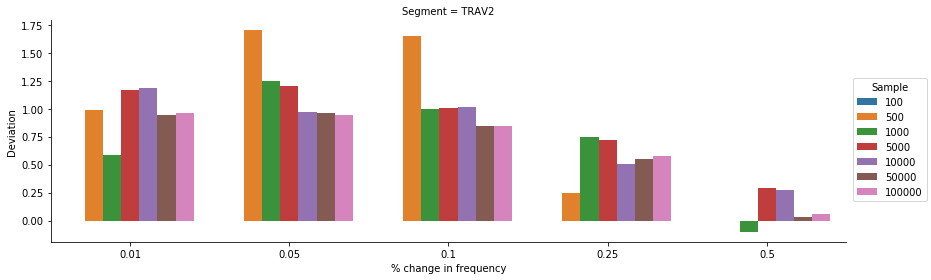

In [134]:
ax = sns.factorplot(x="EffectSize", y="Deviation", kind="bar",
                    row="Segment", aspect=3,
                    hue_order=["100", "500", "1000", "5000", "10000", "50000", "100000"],
                    data=vseg_merge.loc[(vseg_merge["Chain"] == "alpha") & (vseg_merge["Segment"] == lose_trav)], 
                    hue="Sample")

ax.set(ylabel="Deviation", xlabel="% change in frequency")

#plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
plt.savefig(fname="/Users/morgan02/Dropbox/AgeingExperiment/TCR_simulations/TRAV2_deviation-power.png",
           bbox_inches='tight', dpi=300)
plt.show()

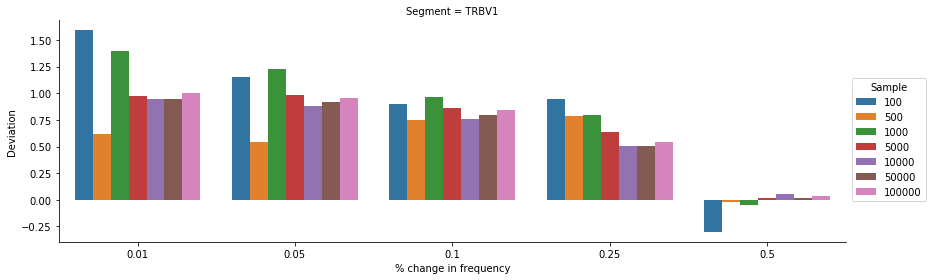

In [135]:
ax = sns.factorplot(x="EffectSize", y="Deviation", kind="bar",
                    row="Segment", aspect=3,
                    hue_order=["100", "500", "1000", "5000", "10000", "50000", "100000"],
                    data=vseg_merge.loc[(vseg_merge["Chain"] == "beta") & (vseg_merge["Segment"] == lose_trbv)], 
                    hue="Sample")

ax.set(ylabel="Deviation", xlabel="% change in frequency")
plt.savefig(fname="/Users/morgan02/Dropbox/AgeingExperiment/TCR_simulations/TRBV1_deviation-power.png",
           bbox_inches='tight', dpi=300)
plt.show()

In [118]:
entropy_perturb = pd.concat(perturb_entropy_dict)
entropy_perturb["Chain"] = ""
entropy_perturb.loc[entropy_perturb["variable"].str.contains("TRA"), "Chain"] = "alpha"
entropy_perturb.loc[entropy_perturb["variable"].str.contains("TRB"), "Chain"] = "beta"
entropy_perturb.head()

variable     value  EffectSize  Sample  Chain
100 0  TRA_CDR3_entropy  2.037734        0.01     100  alpha
    1  TRA_CDR3_entropy  2.163956        0.01     100  alpha
    2  TRA_CDR3_entropy  1.956187        0.01     100  alpha
    3  TRA_CDR3_entropy  2.086769        0.01     100  alpha
    4  TRA_CDR3_entropy  2.118649        0.01     100  alpha

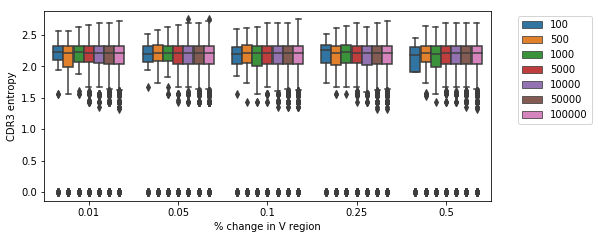

In [27]:
plt.figure(figsize=(8, 3.5))
ax = sns.boxplot(x="EffectSize", y="value", data=entropy_perturb.loc[entropy_perturb["Chain"] == "beta"], 
                 hue="Sample")

ax.set(ylabel="CDR3 entropy", xlabel="% change in V region")

plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
plt.show()

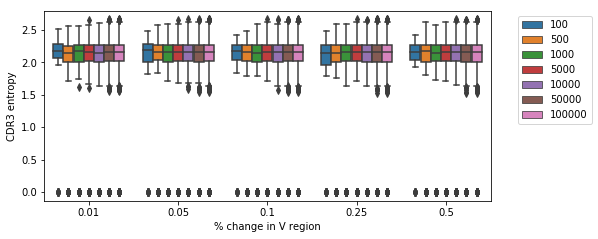

In [28]:
plt.figure(figsize=(8, 3.5))
ax = sns.boxplot(x="EffectSize", y="value", data=entropy_perturb.loc[entropy_perturb["Chain"] == "alpha"], 
                 hue="Sample")

ax.set(ylabel="CDR3 entropy", xlabel="% change in V region")

plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
plt.show()

In [138]:
2160*585

1263600